OCR das placas
===
---

Importando as bibliotecas:

In [6]:
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Carregando todas as ROIs:

In [7]:
dir_path = '/home/nodyer/Área de Trabalho/TG Nodyer/ROI'

files = os.listdir(dir_path)
images_list = []

for file in files:
    img_path = os.path.join(dir_path, file)
    print(img_path)
    source = cv2.imread(img_path)
    images_list.append(source)

/home/nodyer/Área de Trabalho/TG Nodyer/ROI/ROI2.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/ROI/ROI5.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/ROI/ROI6.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/ROI/ROI3.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/ROI/ROI1.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/ROI/ROI4.jpg


Aqui faremos o mesmo pré-processamento feito para gerar as ROI:

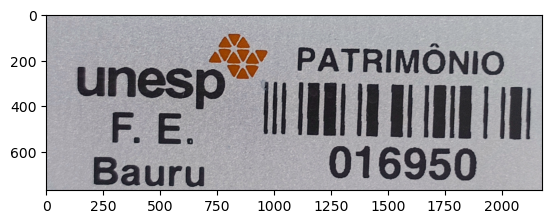

In [8]:
scr = images_list[2]

plt.imshow(scr)
plt.show()

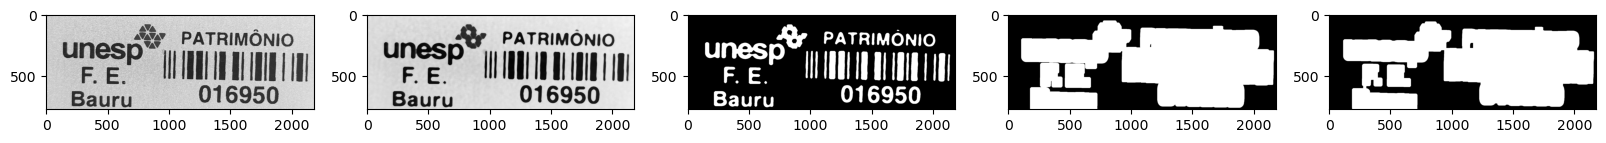

In [12]:
# Transformando em escala de cinza
gray = cv2.cvtColor(scr, cv2.COLOR_BGR2GRAY)

# Aplicando desfoque
median = cv2.medianBlur(gray, 21)

# Binarizando a imagem
_, thresh = cv2.threshold(median,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Dilatando
kernel3 = np.ones((3, 3), np.uint8)
kernel5 = np.ones((5, 5), np.uint8)

dilate = cv2.dilate(thresh, kernel5, iterations=16)
erode = cv2.erode(dilate, kernel3, iterations=8)

plt.figure(figsize=(20,10))

plt.subplot(1,5,1)
plt.imshow(gray, 'gray')

plt.subplot(1,5,2)
plt.imshow(median, 'gray')

plt.subplot(1,5,3)
plt.imshow(thresh, 'gray')

plt.subplot(1,5,4)
plt.imshow(dilate, 'gray')

plt.subplot(1,5,5)
plt.imshow(erode, 'gray')

plt.show()

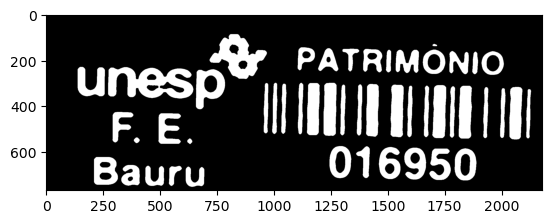

In [5]:
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel5)
plt.imshow(closing, 'gray')
plt.show()

https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html

O threshold foi aplicado o método Otsu.
> Mais detalhes no [LINK](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)

Há uma sugestão de não precisar utilizar o desfoque. Testar essa possibilidade.

Contornos encontrados:  5


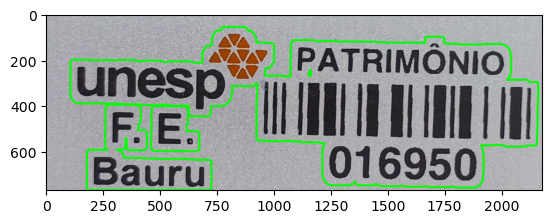

In [6]:
copy = np.copy(scr)
contours, _ = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

print("Contornos encontrados: ", len(contours))

# Visualizando os contornos
cv2.drawContours(copy, contours, -1, (0, 255, 0), 7)

plt.imshow(copy)
plt.show()

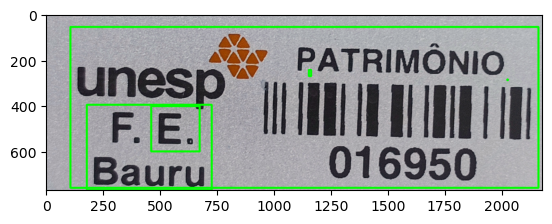

In [7]:
copy2 = np.copy(scr)
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(copy2,(x,y),(x+w,y+h),(0,255,0), 7)

plt.imshow(copy2)
plt.show()

Perímetro:  801.5391039848328
Perímetro:  2182.918827652931
Porporção:  1.464
Perímetro:  6173.256044745445
Perímetro:  5.656854152679443
Perímetro:  63.55634891986847


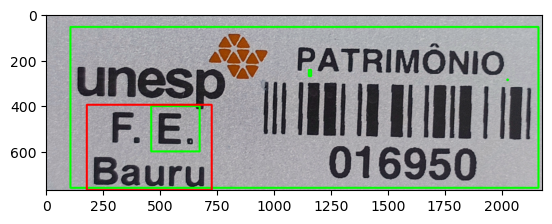

Placas detectadas:  1


In [8]:
roi_list = []

for c in contours:
    x,y,w,h = cv2.boundingRect(c)

    perimeter = cv2.arcLength(c,True)
    print('Perímetro: ', perimeter)

    if perimeter > 1000 and perimeter < 3000:
        proportion = w/h
        print('Porporção: ', w/h)

        if proportion > 1 and proportion < 1.5:
            cv2.rectangle(copy2,(x,y),(x+w,y+h),(255,0,0),7)
            plt.imshow(copy2)
            roi_list.append(c)

plt.show()

print('Placas detectadas: ', len(roi_list))

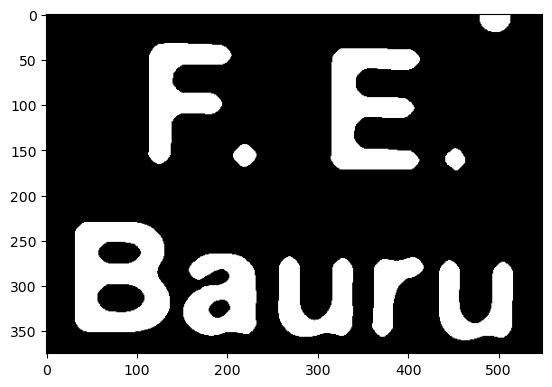

In [9]:
i=1
for item in roi_list:
    x,y,w,h = cv2.boundingRect(item)
    item = thresh[y:y+h,x:x+w]
    plt.subplot(1, len(roi_list), i)
    plt.imshow(item ,'gray')
    i+=1

plt.show()

In [10]:
dirROI = '/home/nodyer/Área de Trabalho/TG Nodyer/OCR'
os.chdir(dirROI)
img_name = 'UA.jpg'

cv2.imwrite(img_name,item)

print("Saved ", os.listdir(dirROI))

Saved  ['UA.jpg']


In [11]:
config_char = r'-c tessedit_char_whitelist=AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz --psm 6 --oem 1'
config_num = r'-c tessedit_char_whitelist=0123456789 --psm 6 --oem 1'

ocr = cv2.imread(dirROI + '/' + img_name)

#numbers = pytesseract.image_to_string(thresh, lang='eng', config=config_num)
chars = pytesseract.image_to_string(ocr, lang='por', config=config_char)

#print('Números detectados: ', numbers)
print('Caracteres detectados: ', chars)

#print(pytesseract.image_to_boxes(thresh))

Caracteres detectados:  FE
Bauru



### `--psm N`
- 0 = Orientation and script detection (OSD) only.
- 1 = Automatic page segmentation with OSD.
- 2 = Automatic page segmentation, but no OSD, or OCR. (not implemented)
- 3 = Fully automatic page segmentation, but no OSD. (Default)
- 4 = Assume a single column of text of variable sizes.
- 5 = Assume a single uniform block of vertically aligned text.
- 6 = Assume a single uniform block of text.
- 7 = Treat the image as a single text line.
- 8 = Treat the image as a single word.
- 9 = Treat the image as a single word in a circle.
- 10 = Treat the image as a single character.
- 11 = Sparse text. Find as much text as possible in no particular order.
- 12 = Sparse text with OSD.
- 13 = Raw line. Treat the image as a single text line,
     bypassing hacks that are Tesseract-specific.

In [4]:
from pyzbar.pyzbar import decode

In [9]:
for code in decode(scr):
    print(code.type)
    print(code.data.decode('utf-8'))

I25
016950


957 355 1169 145


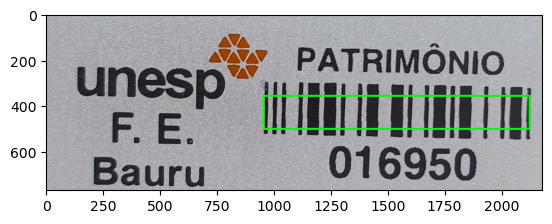

In [11]:
barcodes = decode(scr)
x, y, w, h = barcodes[0].rect
print(x,y,w,h)

draw_bar = np.copy(scr)
cv2.rectangle(draw_bar,(x,y),(x+w,y+h),(0,255,0), 7)

plt.imshow(draw_bar)
plt.show()

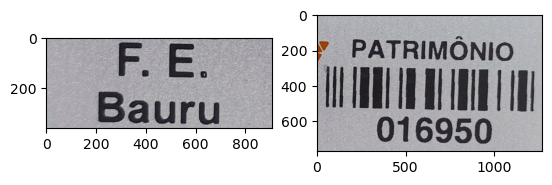

In [45]:
unidade = scr[y+50:,0:x-50]
barra = scr[:,x-50:]

plt.subplot(1,2,1)
plt.imshow(unidade)
plt.subplot(1,2,2)
plt.imshow(barra)
plt.show()

In [46]:
for code in decode(barra):
    print(code.type)
    print(code.data)

I25
b'016950'


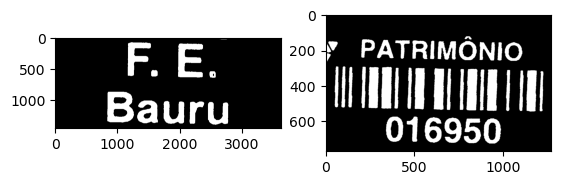

In [51]:
# Transformando em escala de cinza
gray_uni = cv2.cvtColor(unidade, cv2.COLOR_BGR2GRAY)
gray_code = cv2.cvtColor(barra, cv2.COLOR_BGR2GRAY)

# Aplicando desfoque
blur_uni = cv2.GaussianBlur(gray_uni, (21,21), 1)
blur_code = cv2.GaussianBlur(gray_code, (21,21), 1)

# Binarizando a imagem
_, thresh_uni = cv2.threshold(blur_uni,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
_, thresh_code = cv2.threshold(blur_code,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

thresh_uni = cv2.resize(thresh_uni, (0, 0), fx = 4, fy = 4)

plt.subplot(1,2,1)
plt.imshow(thresh_uni, 'gray')
plt.subplot(1,2,2)
plt.imshow(thresh_code, 'gray')
plt.show()

In [52]:
config_char = r'-c tessedit_char_whitelist=AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz --psm 6 --oem 1'
config_num = r'-c tessedit_char_whitelist=0123456789 --psm 6 --oem 1'

chars = pytesseract.image_to_string(thresh_uni, lang='por', config=config_char)
numbers = pytesseract.image_to_string(thresh_code, lang='eng', config=config_num)

print('Caracteres detectados: ', chars)
print('Números detectados: ', numbers)

#print(pytesseract.image_to_boxes(thresh))

Caracteres detectados:  FE
Bauru

Números detectados:  016950

